<h1> <center> GEOG 172: INTERMEDIATE GEOGRAPHICAL ANALYSIS </h1>
    <h2> <center> Evgeny Noi </h2>
        <h3> <center> Lecture 10: Global Spatial Autocorrelation </h3>

# Global Spatial Autocorrrelation 

* Moran's $I$ is just one measure of spatial autocorrelation. There are multiple SA measures. 
* Geary's $c$ 
* Getis and Ord's $G$

# Geary's $c$

$$
C = \dfrac{(n-1)}
          {2 \sum_i \sum_j w_{ij}} 
    \dfrac{\sum_i \sum_j w_{ij} (y_i - y_{j})^2}
          {\sum_i (y_i - \bar{y})^2}
$$

where $n$ is the number of observations, $w_{ij}$ is the cell of binary matrix, and $\bar{y}$ is the sample mean. 

* When compared to Moran’s I, it is apparent both measures compare the relationship of $Y$ within each observation's local neighborhood. 
* Moran’s I takes cross-products on the standardized values, Geary’s C uses differences on the values without any standardization.

In [1]:
from libpysal.examples import load_example
import geopandas as gpd
guerry_loc = load_example('Guerry')
guerry = gpd.read_file(guerry_loc.get_path('guerry.geojson'))
print(guerry.shape)
guerry.head()

Example not available: Guerry
Example not downloaded: Chicago parcels
Example not downloaded: Chile Migration
Example not downloaded: Spirals


(85, 24)


,dept,Region,Dprtmnt,Crm_prs,Crm_prp,Litercy,Donatns,Infants,Suicids,MainCty,...,Infntcd,Dntn_cl,Lottery,Desertn,Instrct,Prsttts,Distanc,Area,Pop1831,geometry
0,1,E,Ain,28870,15890,37,5098,33120,35039,2,...,60,69,41,55,46,13,218.372,5762,346.03,"MULTIPOLYGON (((801150.00000 2092615.00000, 80..."
1,2,N,Aisne,26226,5521,51,8901,14572,12831,2,...,82,36,38,82,24,327,65.945,7369,513.00,"MULTIPOLYGON (((729326.00000 2521619.00000, 72..."
2,3,C,Allier,26747,7925,13,10973,17044,114121,2,...,42,76,66,16,85,34,161.927,7340,298.26,"MULTIPOLYGON (((710830.00000 2137350.00000, 71..."
3,4,E,Basses-Alpes,12935,7289,46,2733,23018,14238,1,...,12,37,80,32,29,2,351.399,6925,155.90,"MULTIPOLYGON (((882701.00000 1920024.00000, 88..."
4,5,E,Hautes-Alpes,17488,8174,69,6962,23076,16171,1,...,23,64,79,35,7,1,320.280,5549,129.10,"MULTIPOLYGON (((886504.00000 1922890.00000, 88..."


In [2]:
from libpysal.weights.contiguity import Queen
import splot
from esda.moran import Moran

y = guerry['Crm_prp'].values
w = Queen.from_dataframe(guerry)
w.transform = 'r'

moran = Moran(y, w)
moran.I

0.26355334031776523

# Geary's C Permutation Inference 

* Inference is performed in a similar way as with Moran’s I. 
* Through simulation we can draw an empirical distribution of the statistic under the null of spatial randomness, and then compare it with the statistic obtained when using the observed geographical distribution of the data. 
* To access the pseudo p-value, calculated as in the Moran case, we can call p_sim:

In [3]:
from esda.geary import Geary

geary = Geary(guerry["Crm_prp"], w)
print(f"The Geary's C is {geary.C}")
print(f"The simulated pseudo p-value is {geary.p_sim}")

The Geary's C is 0.6778380960702041
The simulated pseudo p-value is 0.001


# Getis & Ord's G

* Global version of a family of statistics of spatial autocorrelation based on distance. Originally measure of 'concentration'
* Originally conceived for points, thus we use distances in $W_{ij}$ (as opposed to binary)
* It is designed for the study of positive variables with a natural origin

$$
G(d) = \dfrac{ \sum_i \sum_j w_{ij}(d) \, y_i \, y_j }
             { \sum_i \sum_j y_i \, y_j }
$$

where $w_{ij}(d)$ is the binary weight assigned based on the distance bin. 

# Getis & Ord's G 

* IMPORTANT! Best suited to test to what extent similar values (either high or low) tend to co-locate. $G$ is a statistic of positive spatial autocorrelation. Thus the statistic is not able to pick up cases of negative spatial autocorrelation.

In [4]:
import pandas as pd
from pysal.lib import weights
pts = guerry.centroid
xys = pd.DataFrame({"X": pts.x, "Y": pts.y})
min_thr = weights.util.min_threshold_distance(xys)
min_thr

C:\Users\barguzin\AppData\Local\Temp\ipykernel_11256\1545389804.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pts = guerry.centroid


96726.14323874969

# Getis & Ord's G

* Similarly, inference can also be carried out by relying on computational simulations that replicate several instances of spatial randomness using the values in the variable of interest, but shuffling their locations. In this case, the pseudo P-value computed suggests a clear departure from the hypothesis of no concentration.

In [5]:
from esda.getisord import G

w_db = weights.DistanceBand.from_dataframe(guerry, min_thr)
gao = G(guerry["Crm_prp"], w_db)
print(
    "Getis & Ord G: %.3f | Pseudo P-value: %.3f" % (gao.G, gao.p_sim)
)

Getis & Ord G: 0.049 | Pseudo P-value: 0.001


C:\Users\barguzin\Anaconda3\envs\geo_env\lib\site-packages\esda\getisord.py:167: RuntimeWarning: overflow encountered in longlong_scalars
  EG2DEN = ((sum(y) ** 2 - sum(y2)) ** 2) * n * (n - 1) * (n - 2) * (n - 3)


# Bivariate Moran's

> The concept of bivariate spatial correlation is complex and often misinterpreted. It is typically considered to be the correlation between one variable and the spatial lag of another variable, as originally implemented in the precursor of GeoDa (e.g., as described in Anselin, Syabri, and Smirnov 2002). However, this does not take into account the inherent correlation between the two variables. More precisely, the bivariate spatial correlation is between $x_i$ and $\Sigma_j w_{ij}y_{j}$, but does not take into account the correlation between $x_i$ and $y_i$, i.e., between the two variables at the same location. <...> As a result, this statistic is often interpreted incorrectly, as it may overestimate the spatial aspect of the correlation that instead may be due mostly to the in-place correlation.

[source](https://geodacenter.github.io/workbook/5b_global_adv/lab5b.html)

# Bivariate Moran's 

* In its initial conceptualization, as mentioned above, a bivariate Moran scatter plot extends the idea of a Moran scatter plot with a variable on the x-axis and its spatial lag on a y-axis to a bivariate context. The fundamental difference is that in the bivariate case the spatial lag pertains to a different variable. 

$$
I_B = \frac{\sum_i (\sum_j w_{ij} y_j \times x_i)}{ \sum_i x_i^2},
$$

In [6]:
from esda.moran import Moran_BV

x = guerry['Litercy'].values
y = guerry['Crm_prp'].values

moran_bv = Moran_BV(y, x, w)
print(f"Bivariate Moran's I: {round(moran_bv.I, 3)}")

Bivariate Moran's I: -0.316


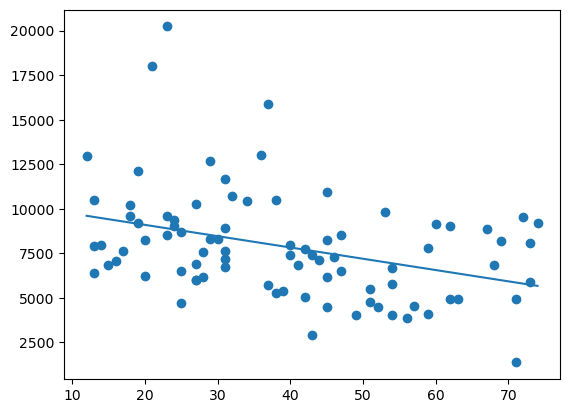

In [7]:
import scipy 
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(x,y)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))

r, p = scipy.stats.pearsonr(x, y) 

C:\Users\barguzin\Anaconda3\envs\geo_env\lib\site-packages\splot\_viz_esda_mpl.py:628: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran_bv.sim, shade=shade, color=color, ax=ax, **kwargs)


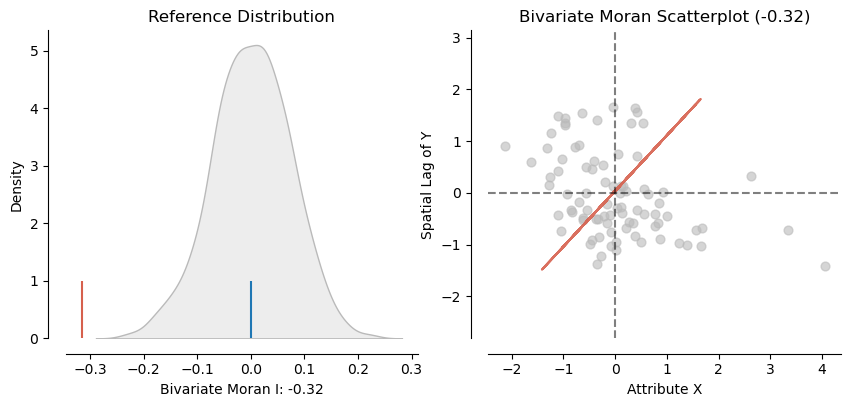

In [8]:
from splot.esda import plot_moran_bv_simulation, plot_moran_bv
import matplotlib.pyplot as plt

plot_moran_bv(moran_bv)
plt.show()

# Bivariate Moran Facet Matrix

In [9]:
from esda.moran import Moran_BV_matrix
from splot.esda import moran_facet
guerry_vars = guerry[['Crm_prs', 'Litercy', 'Donatns', 'Wealth']]
matrix = Moran_BV_matrix(guerry_vars, w)

moran_facet(matrix)
fig = plt.gcf()
fig.savefig('moran_facet.png')
plt.close()

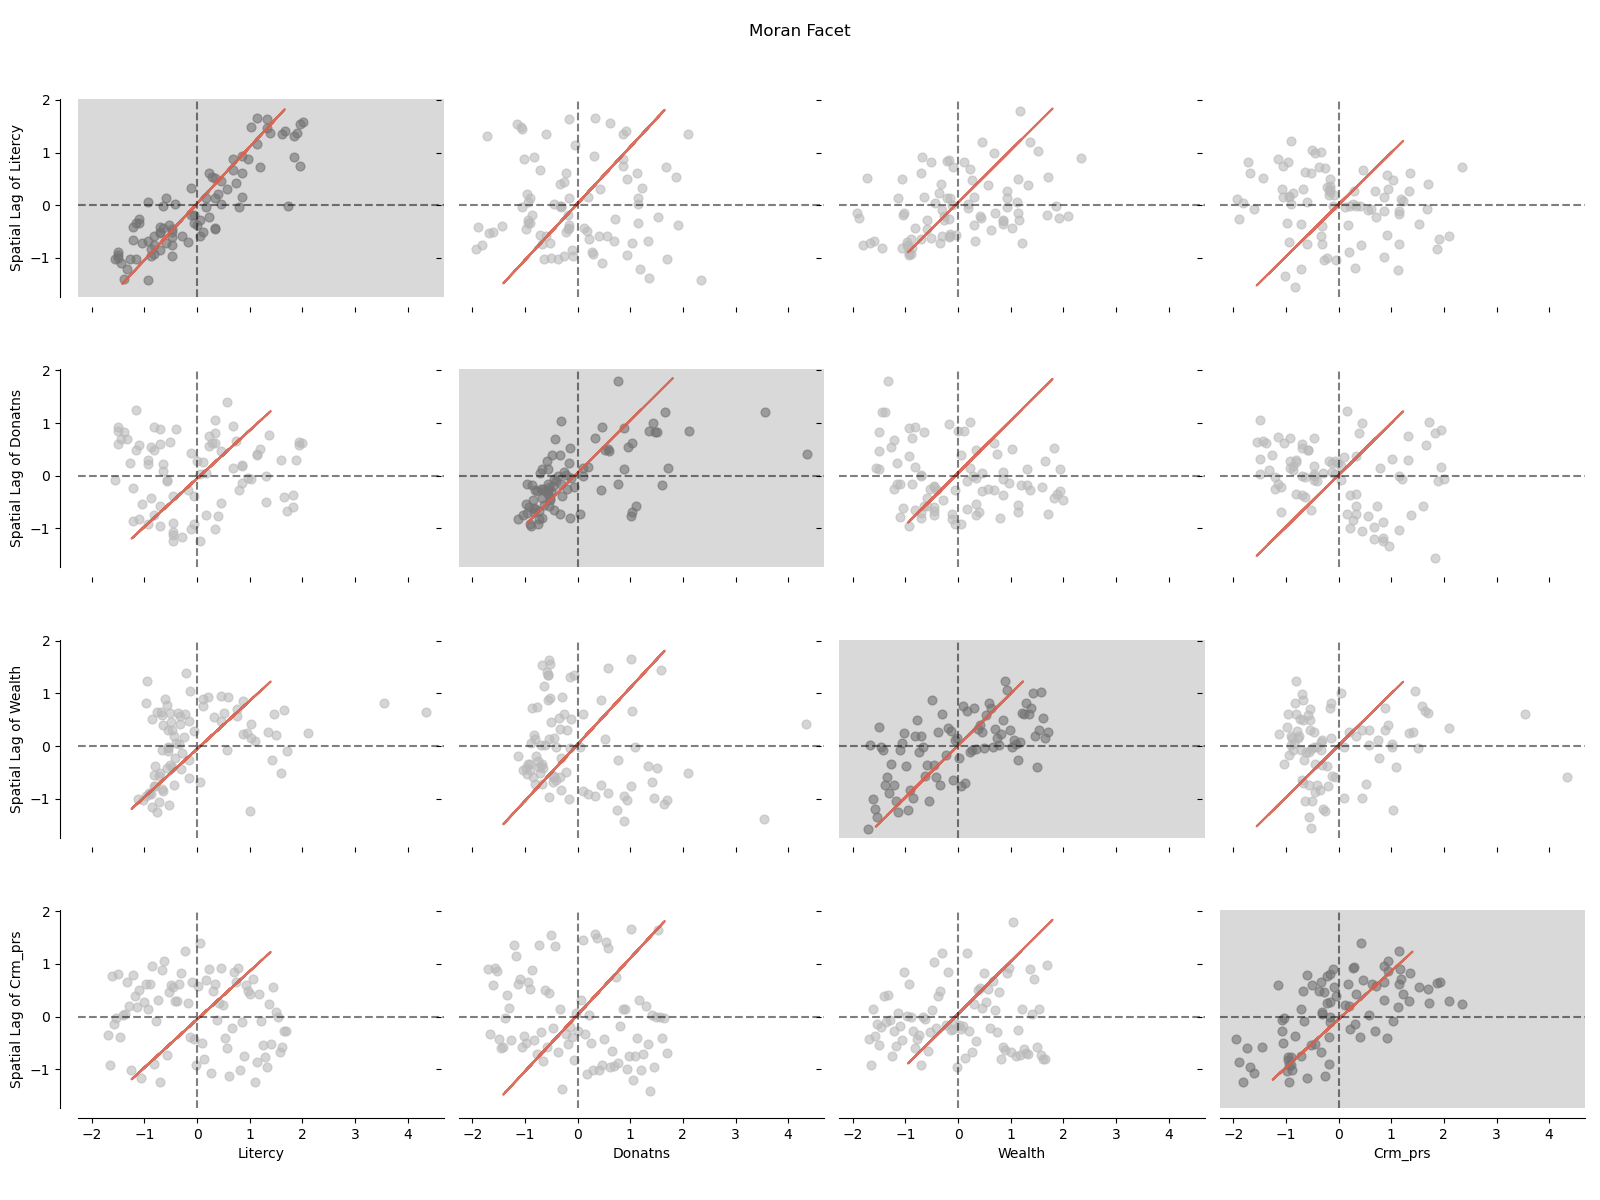

In [10]:
from IPython.display import Image
Image(filename='moran_facet.png') 

# Even more types of autocorrelating one variable

* Differential Moran's $I$ 
* Moran's Scatter plot for EB rates 
* Spatial correlogram 

#### Check out [GeoDa documentation](https://geodacenter.github.io/documentation.html) for more details. 

# GeoDa

<img src="https://geodacenter.github.io/images/nonspatial_clusters.png" width="500px">

# GeoDa 

* Basic Mapping 
* E(S)DA 
* Spatial Weights 
* Global Spatial Autocorrelation  
* Local Spatial Autocorrelation 
* Clustering / Regionalization
* Dimension reduction 